Dataset: http://nlp.uit.edu.vn/datasets/

Classify 7 states of emotions in terms of enjoyment, disgust, sadness, anger, surprise, fear and others from text using PhoBert, a state of the art pre-trained BERT for the Vietnamese language

From UIT with ♥

### About data:

Emotion recognition is a higher approach or special case of sentiment analysis. In this task, the result is not produced in terms of either polarity: positive or negative or in the form of rating (from 1 to 5) but of a more detailed level of sentiment analysis in which the result are depicted in more expressions like sadness, enjoyment, anger, disgust, fear and surprise. Emotion recognition plays a critical role in measuring brand value of a product by recognizing specific emotions of customers’ comments. In this study, we have achieved two targets. First and foremost, we built a standard Vietnamese Social Media Emotion Corpus (UIT-VSMEC) with about 6,927 human-annotated sentences with six emotion labels, contributing to emotion recognition research in Vietnamese which is a low-resource language in Natural Language Processing (NLP). Secondly, we assessed and measured machine learning and deep neural network models on our UIT-VSMEC. As a result, Convolutional Neural Network (CNN) model achieved the highest performance with 57.61% of F1-score.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set Up

In [3]:
# For read excel format form pandas
!pip install openpyxl

In [4]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [5]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 6
N_SPLITS = 5

### Load Data

In [7]:
def get_data(path):
    df = pd.read_excel(path, sheet_name=None)['Sheet1']
    df.columns = ['index', 'Emotion', 'Sentence']
    # unused column
    df.drop(columns=['index'], inplace=True)
    return df

train_df = get_data('//content/drive/MyDrive/DATA_DAP/train_nor_811_preprocessed_modified.xlsx')
valid_df = get_data('/content/drive/MyDrive/Dataclean/valid_nor_811.xlsx')
test_df = get_data('/content/drive/MyDrive/Dataclean/test_nor_811.xlsx')

# We will use Kfold later
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
    train_df.loc[val_, "kfold"] = fold

In [8]:
train_df.sample(5)

,Emotion,Sentence,kfold
2944,Anger,ơi mua đập phát vào mặt tụi chê đi,0.0
8185,Surprise,tin tức đó làm không thể nào tin,4.0
7833,Surprise,không thể tưởng tượng nổi rằng cuộc sống lại m...,2.0
6098,Anger,cảm thấy như đang bị bao phủ bởi sự đen tối củ...,3.0
2234,Enjoyment,má nhện cười đau cả ruột,2.0


In [9]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9031 entries, 0 to 9030
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   9031 non-null   object 
 1   Sentence  9030 non-null   object 
 2   kfold     9031 non-null   float64
dtypes: float64(1), object(2)
memory usage: 211.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693 entries, 0 to 692
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   693 non-null    object
 1   Sentence  693 non-null    object
dtypes: object(2)
memory usage: 11.0+ KB


(None, None)

<Axes: xlabel='Emotion', ylabel='count'>

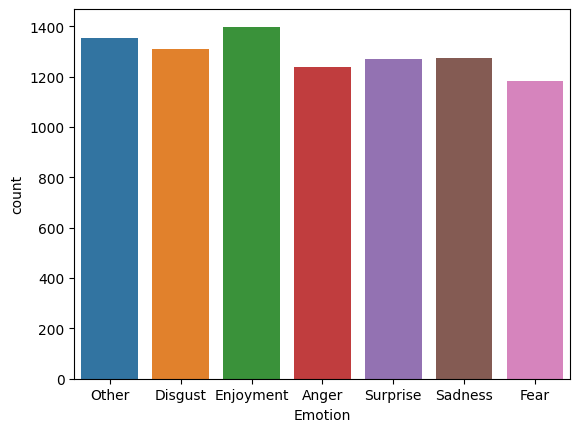

In [10]:
sns.countplot(x='Emotion', data=train_df)

**=> Imbalanced labels! But We still want to classify 7 classes**

### DataLoader

In [11]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [12]:
from gensim.utils import simple_preprocess
from torch.utils.data import Dataset
import torch

class SentimentDataset(Dataset):
    # ... other parts of the class ...

    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def get_input_data(self, row):
        # Assuming that each row has 'Sentence' and 'Emotion' columns
        text = row['Sentence']
        label = self.labelencoder(row['Emotion'])
        return text, label

    def labelencoder(self, text):
        # Example of label encoding, replace with your actual labels
        mapping = {
            'Enjoyment': 0,
            'Disgust': 1,
            'Sadness': 2,
            'Anger': 3,
            'Surprise': 4,
            'Fear': 5,
            'Other': 6
        }
        return mapping.get(text, -1)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Ensure text is a string
        text = str(text)

        # Use simple_preprocess
        text = ' '.join(simple_preprocess(text))

        # Tokenization and encoding
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    # ... any other methods or parts of the class ...


**BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length.**

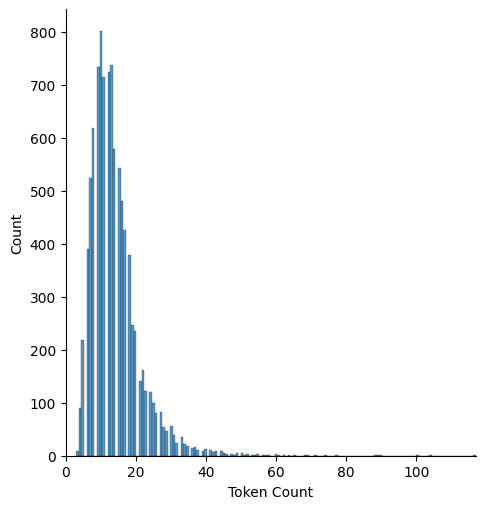

In [13]:
from gensim.utils import simple_preprocess
from transformers import AutoTokenizer
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df and test_df are defined and have a column 'Sentence'
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()

# Convert all elements to strings and preprocess
all_data = [' '.join(simple_preprocess(str(text))) for text in all_data]

# Load your tokenizer (replace 'your-tokenizer' with the actual tokenizer you are using)
tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')

# Tokenize and get token lengths
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]

# Plot
sns.displot(token_lens)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')
plt.show()


**=> Choose a maximum of length of 50 is safe.**

### Model

In [14]:
import torch.nn as nn
from transformers import AutoModel

class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        # Getting the output from BERT
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # The first element of output is the last hidden state
        last_hidden_state = output.last_hidden_state

        # We usually use the output of the first token (CLS token) for classification tasks
        cls_output = last_hidden_state[:, 0, :]

        # Apply dropout and pass through the fully connected layer
        x = self.drop(cls_output)
        x = self.fc(x)
        return x


### Train & Eval Function

In [15]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


### Training with K-Fold

In [16]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)

    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

    return train_loader, valid_loader

In [17]:
for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=7).to(device)
    criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
    optimizer = AdamW(model.parameters(), lr=2e-5)

    lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
    best_acc = 0
    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc

-----------Fold: 1 ------------------


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch 1/6
------------------------------
Train Accuracy: 0.6197397563676633 Loss: 1.097196513506691
Valid Accuracy: 0.4338682899833979 Loss: 1.758835709727971
Epoch 2/6
------------------------------
Train Accuracy: 0.7846068660022149 Loss: 0.643071805646198
Valid Accuracy: 0.4532374100719424 Loss: 1.7147714606428568
Epoch 3/6
------------------------------
Train Accuracy: 0.8453765227021041 Loss: 0.4847976591240252
Valid Accuracy: 0.4488101826231322 Loss: 1.8170501099223584
Epoch 4/6
------------------------------
Train Accuracy: 0.8918881506090808 Loss: 0.3574218563323395
Valid Accuracy: 0.45655783065855005 Loss: 1.9699179087064962
Epoch 5/6
------------------------------
Train Accuracy: 0.9163898117386489 Loss: 0.2785978171916728
Valid Accuracy: 0.4681793027116768 Loss: 2.0477841227455476
Epoch 6/6
------------------------------
Train Accuracy: 0.933001107419712 Loss: 0.22225795957812033
Valid Accuracy: 0.45877144438295514 Loss: 2.113887509413525
-----------Fold: 2 -----------------

In [18]:
def test(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=7)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)

        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [19]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test(test_loader)

              precision    recall  f1-score   support

           0       0.81      0.66      0.73       193
           1       0.67      0.70      0.69       132
           2       0.78      0.75      0.76       116
           3       0.55      0.60      0.57        40
           4       0.84      0.73      0.78        37
           5       0.81      0.76      0.79        46
           6       0.62      0.79      0.69       129

    accuracy                           0.72       693
   macro avg       0.73      0.71      0.72       693
weighted avg       0.73      0.72      0.72       693



### Heatmap between Predict and Ground Truth

<Axes: >

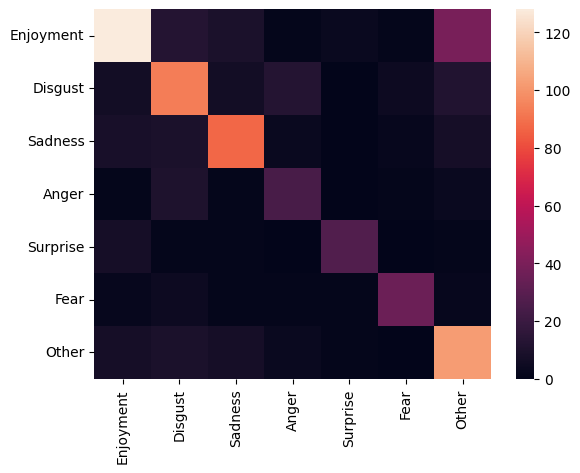

In [20]:
class_names = ['Enjoyment', 'Disgust', 'Sadness', 'Anger', 'Surprise', 'Fear', 'Other']
sns.heatmap(confusion_matrix(real_values, predicts), annot=False, xticklabels = class_names, yticklabels = class_names)

### Visualize Wrong Predicted Label

In [21]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
cho nghỉ viêc mói đúng sao goi là kỷ luật
Predicted: (Other) --vs-- Real label: (Disgust)
--------------------------------------------------
nhà thì không xa lắm nhưng chưa bao giờ đi vì sợ bị đè bẹp luôn người =)))))
Predicted: (Other) --vs-- Real label: (Enjoyment)
--------------------------------------------------
bố không thích nộp đấy mày thích ý kiến không
Predicted: (Anger) --vs-- Real label: (Disgust)
--------------------------------------------------
một hành động đẹp đầy tính nhân văn ☺️☺️
Predicted: (Other) --vs-- Real label: (Enjoyment)
--------------------------------------------------
ủa má . 2 đứa yêu nhau vô duyên và sân si giống nhau vậy ?
Predicted: (Sadness) --vs-- Real label: (Disgust)
--------------------------------------------------
sống 17 năm chưa crush ai bao giờ
Predicted: (Anger) --vs-- Real label: (Enjoyment)
--------------------------------------------------
nghe ngọt thế :((
Predicted: (Enjoyment) --vs-- 

### Inference

In [22]:
def infer(text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {class_names[y_pred]}')

In [23]:
infer('Nhiều người thích bao biện cái sự vô duyên bằng 2 chữ "sự thật "🙂', tokenizer)

Text: Nhiều người thích bao biện cái sự vô duyên bằng 2 chữ "sự thật "🙂
Sentiment: Disgust
